# Introducción


## Objetivo

Utilizar Llama 2.0, Langchain y ChromaDB para crear un sistema de Generación con Recuperación Mejorada (RAG). Esto nos permitirá hacer preguntas sobre nuestros documentos (que no se incluyeron en los datos de entrenamiento), sin necesidad de ajustar finamente el Modelo de Lenguaje Grande (LLM, por sus siglas en inglés).
Cuando se utiliza RAG, si se plantea una pregunta, primero se realiza un paso de recuperación para obtener documentos relevantes de una base de datos especial, una base de datos vectorial donde se indexaron estos documentos.

## Definiciones

* LLM - Modelo de Lenguaje Grande (Large Language Model)
* Llama 2.0 - LLM de Meta
* Langchain - un marco diseñado para simplificar la creación de aplicaciones utilizando LLM
* Base de datos vectorial - una base de datos que organiza datos a través de vectores de alta dimensión
* ChromaDB - base de datos vectorial
* RAG - Generación con Recuperación Mejorada (consulte más detalles sobre RAG a continuación)

## Detalles del modelo

* **Modelo**:  Mistral
* **Variante**: 7b-v0.1-hf (7b: 7B dimm. hf: HuggingFace build)
* **Versión**: V1
* **Framework**: PyTorch



## ¿Qué es un sistema de Generación con Recuperación Mejorada (RAG)?

Los Modelos de Lenguaje Grande (LLM) han demostrado su capacidad para comprender el contexto y proporcionar respuestas precisas a diversas tareas de Procesamiento de Lenguaje Natural (NLP), incluyendo la resumen, preguntas y respuestas, cuando se les solicita. Si bien son capaces de proporcionar respuestas muy buenas a preguntas sobre información con la que fueron entrenados, tienden a alucinar cuando el tema trata sobre información que "no saben", es decir, no estaba incluida en sus datos de entrenamiento. La Generación con Recuperación Mejorada combina recursos externos con LLM. Por lo tanto, los dos componentes principales de un sistema RAG son un recuperador y un generador.

La parte del recuperador se puede describir como un sistema que es capaz de codificar nuestros datos para que se puedan recuperar fácilmente las partes relevantes al consultarlos. La codificación se realiza utilizando incrustaciones de texto, es decir, un modelo entrenado para crear una representación vectorial de la información. La mejor opción para implementar un recuperador es una base de datos vectoriales. Como bases de datos vectoriales, existen múltiples opciones, tanto productos de código abierto como comerciales. Algunos ejemplos son ChromaDB, Mevius, FAISS, Pinecone, Weaviate. Nuestra opción en este cuaderno será una instancia local de ChromaDB (persistente).

Para la parte del generador, la opción más obvia es un LLM. En este cuaderno utilizaremos un modelo LLaMA v2 cuantificado, de la colección de Modelos de Kaggle.

La orquestación del recuperador y el generador se realizará utilizando Langchain. Una función especializada de Langchain nos permite crear el recuperador-generador en una sola línea de código.

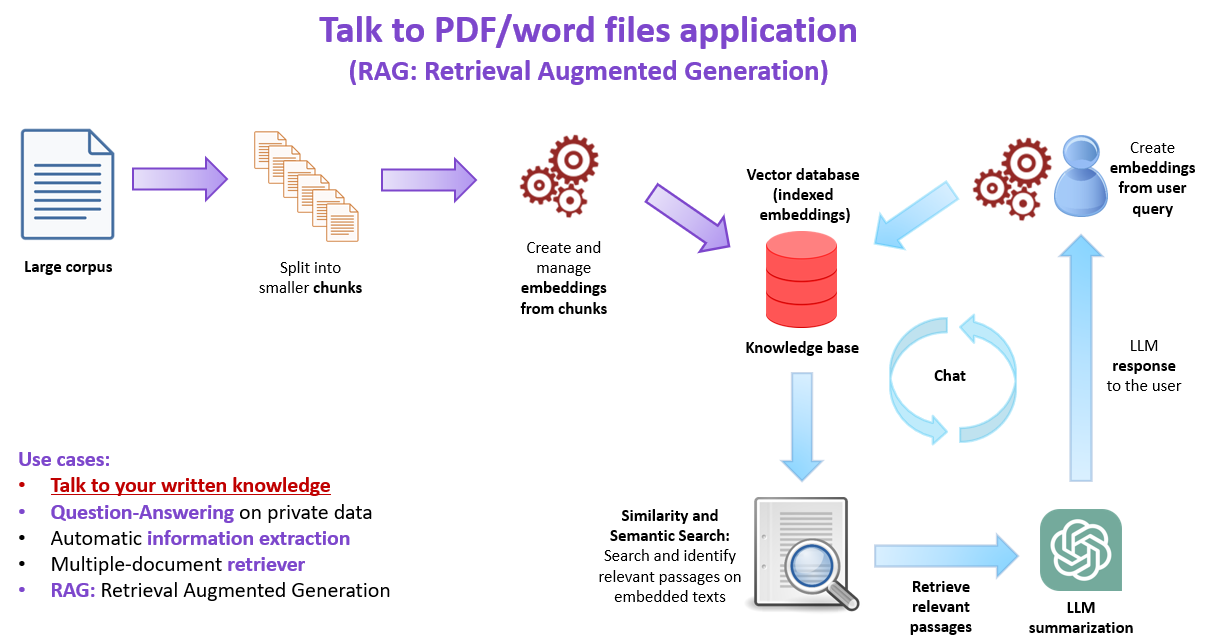

# Installations, imports, utils

In [51]:
%%time

!pip install -q -U langchain faiss-gpu
!pip install -q -U InstructorEmbedding sentence_transformers
!pip install huggingface_hub -q
!pip install gradio -q
!pip install watermark -q
!pip install docx2txt

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/opt/conda/lib/python3.10/site-packages/anyio-3.7.0.dist-info/METADATA'

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/opt/conda/lib/python3.10/site-packages/typing_extensions-4.6.3.dist-info/METADATA'

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/opt/conda/lib/python3.10/site-packages/typing_extensions-4.6.3.dist-info/METADATA'

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/opt/conda/lib/python3.10/site-packages/typing_extensions-4.6.3.dist-info/METADATA'

CPU times: user 367 ms, sys: 138 ms, total: 505 ms
Wall time: 35.1 s


In [36]:
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-11-07T15:54:13.150304+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.15.133+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit



## Imports

In [63]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import textwrap
import time

import langchain

# loaders
from langchain import document_loaders
from bs4 import BeautifulSoup as Soup

# splits
from langchain.text_splitter import RecursiveCharacterTextSplitter

# prompts
from langchain import PromptTemplate, LLMChain

# vector stores
from langchain.vectorstores import FAISS

# models
from langchain.llms import HuggingFacePipeline
from InstructorEmbedding import INSTRUCTOR
from langchain.embeddings import HuggingFaceInstructEmbeddings

# retrievers
from langchain.chains import RetrievalQA

import torch

In [4]:
%watermark --iversions

langchain: 0.0.331
torch    : 2.0.0



## CFG
Clase para facilitar la experimentación

In [259]:
class CFG:
    # LLMs
    model_name = 'mistralai/Mistral-7B-Instruct-v0.1'
    temperature = 0.5
    top_p = 0.95
    repetition_penalty = 1.15
    do_sample = True
    max_new_tokens = 1024
    num_return_sequences=1

    # splitting
    split_chunk_size = 1000
    split_overlap = 50
    
    # embeddings
    embeddings_model_repo = 'sentence-transformers/all-MiniLM-L6-v2'

    # similar passages
    k = 5
    
    # paths
    Embeddings_path =  '/kaggle/working/faiss_index_hp'
    #Persist_directory = './harry-potter-vectordb'
    # Persist_directory = './data-viz-vectordb'

# Definir modelo
Preparar el modelo y el tokenizador.

In [260]:
# Create a free read HF token: https://huggingface.co/settings/tokens
# Use Kaggle Secrets: Add-ons, Secrets, add secret

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
huggingfacehub_api_token = user_secrets.get_secret("hf_token")

Definir el query pipeline

In [261]:
from langchain.llms import HuggingFaceHub

llm = HuggingFaceHub(
    repo_id = CFG.model_name,
    model_kwargs={
        "max_new_tokens": CFG.max_new_tokens,
        "temperature": CFG.temperature,
        "top_p": CFG.top_p,
        "repetition_penalty": CFG.repetition_penalty,
        "do_sample": CFG.do_sample,
        "num_return_sequences": CFG.num_return_sequences        
    },
    huggingfacehub_api_token = huggingfacehub_api_token
)

In [262]:
%%time
# We use the prompt template used to train the Mistral Instruct model
# See https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1
print(llm("""<s>[INST] Give me 5 examples of cool potions and explain what they do. [/INST]""", raw_response=True).strip())

1) Invisibility Potion: This potion, when consumed, renders the drinker invisible to the naked eye for a limited period of time. It works by disrupting the light waves that the human body reflects, making it difficult to detect the presence of an object or person.
2) Love Potion: A love potion is a magical brew that is said to induce intense feelings of love and affection between two people. The exact formula varies from potion maker to potion maker, but typically includes ingredients like rose petals, moonbeam essence, and a pinch of cupid's arrow dust.
3) Healing Potion: This potion can cure injuries, illnesses, and diseases by restoring the body's natural healing processes. It usually contains ingredients such as rare herbs, enchanted crystals, and sometimes even a drop of dragon's blood.
4) Mind-Control Potion: This potion can be used to control the thoughts and actions of others. It often requires the drinker to consume a small amount of the potion, after which they will have the 

## Loader



In [263]:
%%time

# Adquirir datos de distintas fuentes
loaders = [
    document_loaders.Docx2txtLoader("/kaggle/input/tfg-datasetstest/Listado Preguntas-Respuestas - ONLINE.docx"),
    #document_loaders.Docx2txtLoader("/kaggle/input/tfg-datasetstest/Listado Preguntas-Respuestas - PRESENCIAL.docx"),
    #document_loaders.TextLoader("/kaggle/input/tfg-datasetstest/Listado Preguntas-Respuestas - ONLINE.txt", encoding='utf8'),
    #document_loaders.PyPDFLoader("/kaggle/input/tfg-datasetstest/2-entrega_proyecto_fin_de_grado_vena.pdf"),
    #document_loaders.PyPDFLoader("/kaggle/input/tfg-datasetstest/3-vena-modelo_informe_tutor_academico_modificado.pdf"),
    #document_loaders.PyPDFLoader("/kaggle/input/tfg-datasetstest/reglamentp_tfg-tfm_aprob._08-06-2022.pdf"),
    #document_loaders.GitHubIssuesLoader(repo="langchain-ai/langchain",access_token=ACCESS_TOKEN, creator="UmerHA",)
    
    #document_loaders.RecursiveUrlLoader(url="https://clopezno.github.io/tfg_gii_online/HistoricoSist.html", max_depth=2, extractor=lambda x: Soup(x, "html.parser").text),
    
    #document_loaders.WebBaseLoader("https://www.ubu.es/grado-en-ingenieria-informatica/informacion-basica/trabajo-fin-de-grado")   
]

documents = []

for loader in loaders:
    documents.extend(loader.load())

CPU times: user 53.7 ms, sys: 0 ns, total: 53.7 ms
Wall time: 56.2 ms


In [264]:
print(f'Tenemos {len(documents)} paginas en total')

Tenemos 1 paginas en total


In [265]:
documents[0].page_content

'Intent\n\nEjemplo mensaje usuario\n\nRespuesta\n\nadios\n\nAdiós\n\nEspero haber sido de utilidad. Un saludo :)\n\nadjuntar_videos\n\n¿Se pueden adjuntar videos en el depósito del TFG??\n\nNo se pueden adjuntar videos en el depósito. Se subirá un documento con los enlaces a dichos vídeos que deberán estar colgados en YouTube.\n\nayuda_profesor\n\n¿Me ayudará algún profesor?\n\nEl principal apoyo para ayudarte con tu TFG será tu tutor o tutora. En caso de que haya algún problema concreto que necesite la consulta a otros profesores él o ella te lo indicará.\n\ncambiar\n\n¿Puedo cambiar de tutor o tema?\n\nEl estudiante que quiera realizar un cambio de tutor y/o tema deberá solicitarlo al Tribunal por escrito, de manera motivada, en el plazo máximo de un mes desde la fecha de la publicación de la asignación. El Tribunal estará obligado a contestar al alumno por escrito en un plazo máximo de siete días hábiles. En dicho escrito se motivará la resolución del TFG/TFM a la petición del alumn

## Splitter

In [266]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = CFG.split_chunk_size,
    chunk_overlap = CFG.split_overlap
)

texts = text_splitter.split_documents(documents)
len(texts)

31

## Embeddings

### Create vector database

We need to create the embeddings only once, and then we can just load the vector store and query the database using similarity search.

Loading the embeddings takes only a few seconds.

I uploaded the embeddings to a Kaggle Dataset so we just load it from here.



In [268]:
# %%time

# ### download embeddings model
# embeddings = HuggingFaceInstructEmbeddings(
#     model_name = CFG.embeddings_model_repo,
#     model_kwargs = {"device": "cuda"}
# )

# ### create embeddings and DB
# vectordb = FAISS.from_documents(
#     documents = texts, 
#     embedding = embeddings
# )

# ### persist vector database
# vectordb.save_local("faiss_index_hp")

### Load vector database
After saving the vector database, we just load it from the Kaggle Dataset I mentioned

Obviously, the embeddings function to load the embeddings must be the same as the one used to create the embeddings

In [269]:
%%time

### download embeddings model
embeddings = HuggingFaceInstructEmbeddings(
    model_name = CFG.embeddings_model_repo,
    model_kwargs = {"device": "cuda"}
)

### load vector DB embeddings
vectordb = FAISS.load_local(
    CFG.Embeddings_path,
    embeddings
)

load INSTRUCTOR_Transformer
max_seq_length  512
CPU times: user 276 ms, sys: 59.2 ms, total: 335 ms
Wall time: 300 ms


In [270]:
### test if vector DB was loaded correctly
vectordb.similarity_search('repositorio')

[Document(page_content='Título_ memoria\n\nNombre pdf de la memoria\n\nEl título debe describir clara y brevemente el objetivo del TFG. Junto con una frase descriptiva, se puede añadir un nombre comercial del producto desarrollado. Esto es de elección libre a consensuar entre el tutor/a y el alumno/a.\n\nSin tutor\n\n¿Puedo realizar TFG sin tutor?\n\nNo, no se puede realizar el TFG sin tutor.\n\nRepositorio\n\n¿Cómo usar el repositorio?\n\nEl uso de repositorios de software y gestores de tareas se explican en la asignatura de gestión de proyectos. Puedes consultar algunos los vídeos de la asignatura en la siguiente lista de reproducción https://www.youtube.com/playlist?list=PLZ9ew3yS01RTLJvA3Ym85ePswWBhNWzNr \n\nCopia impresa si no vivo en Burgos\n\n¿Cómo envío la copia impresa de la memoria a la secretaria si vivo fuera de Burgos?\n\nEn la modalidad online no se entrega copia impresa.\n\nEjemplo TFG\n\nQuiero ver un ejemplo de TFG', metadata={'source': '/kaggle/input/tfg-datasetstest/

## Prompt Template

Custom prompt

In [271]:
# we get the context part by embedding retrieval 
prompt_template = """<s>[INST] You are given the context after <<CONTEXT>> and a question after <<QUESTION>>.

Answer the question by ONLY using the information in <<CONTEXT>>. Only base your answer on the information in the <<CONTEXT>>.

<<QUESTION>>{question}\n<<CONTEXT>>{context} [/INST]"""

PROMPT = PromptTemplate(
    template = prompt_template, 
    input_variables = ["question", "context"]
)

In [272]:
llm_chain = LLMChain(prompt=PROMPT, llm=llm)

In [273]:
answer = llm_chain.run(question="Give me 5 examples of cool potions and explain what they do.", context="")

print(answer.strip())

Unfortunately, there is no context provided for me to generate an answer based on. Could you please provide more details or clarify your question?


In [274]:
answer = llm_chain.run(question="Dame 5 ejemplos de pociones y lo que pueden hacer.", context="")

print(answer.strip())

I'm sorry, but there is no context provided for me to generate an answer based on. Could you please provide more information or clarify the context?


## Retriever chain


In [275]:
retriever = vectordb.as_retriever(search_kwargs = {"k": CFG.k, "search_type" : "similarity"})

qa_chain = RetrievalQA.from_chain_type(
    llm = llm,
    chain_type = "stuff", # map_reduce, map_rerank, stuff, refine
    retriever = retriever, 
    chain_type_kwargs = {"prompt": PROMPT},
    return_source_documents = True,
    verbose = False
)

In [276]:
### testing MMR search
question = "¿Puedo cambiar de tutor o tema?"
vectordb.max_marginal_relevance_search(question, k = CFG.k)

[Document(page_content='https://www.ubu.es/acceso-admision-y-matricula/matricula/matricula-de-grado/precios-publicos/escuela-politecnica-superior/grado-en-ingenieria-informatica\n\ntema_que_quiera\n\n¿Puedo hacerlo del tema que quiera?\n\nHay varias modalidades de oferta de TFG. La modalidad C acepta propuestas de TFG que ofertan los alumnos, siempre que se adecúen al perfil de conocimientos de los tutores online y estén correctamente descritas y justificadas con trabajos y asignaturas relacionadas. En función de que se cumplan o no estos requisitos las propuestas pueden ser aceptadas o rechazadas por el tribunal.  Las propuesta deberán ser enviadas y resueltas por el tribunal durante el primer mes del cuatrimestre.\n\ntema_si_suspendo\n\n¿Puedo repetir el tema si suspendo?', metadata={'source': '/kaggle/input/tfg-datasetstest/Listado Preguntas-Respuestas - ONLINE.docx'}),
 Document(page_content='como_elijo_tutor\n\n¿Cómo elijo tutor?\n\nEn la modalidad C de oferta de TFG por el alumno

## Post-process outputs
* Format llm response
* Cite sources (PDFs)
* Change width parameter to format the output

In [254]:
def wrap_text_preserve_newlines(text, width=700):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text


def process_llm_response(llm_response):
    ans = wrap_text_preserve_newlines(llm_response['result'])
    '''
    sources_used = ' \n'.join(
        [
            source.metadata['source'].split('/')[-1][:-4] + ' - page: ' + str(source.metadata['page'])
            for source in llm_response['source_documents']
        ]
    )
    
    ans = ans + '\n\nSources: \n' + sources_used
    '''
    
    
    return ans

In [255]:
def llm_ans(query):
    start = time.time()
    llm_response = qa_chain(query)
    ans = process_llm_response(llm_response)
    end = time.time()

    time_elapsed = int(round(end - start, 0))
    time_elapsed_str = f'\n\nTime elapsed: {time_elapsed} s'
    return ans.strip() + time_elapsed_str

## Ask questions

In [277]:
query = "¿Como puedo cambiar de tutor o topic?"
print(llm_ans(qa_chain(query)))

To change tutor or topic for the TFG, you need to identify the key concepts required for the project and find professors who teach those subjects. For example, if you're working on a thesis related to computer science, you should look for professors who specialize in that area. It is recommended to have at least one tutor who teaches a common subject or specific technology within your field of study. If you're doing an online thesis, it is also important to have a tutor who has experience teaching online.

Time elapsed: 0 s


## References

* https://www.kaggle.com/code/paultimothymooney/how-to-use-mistral-from-kaggle-models
* https://www.kaggle.com/code/acorn8/q-a-with-llms-harry-potter-mistral-hf-api/comments
* https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1